In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
import project_path
from db_importer.settings import *
import scipy.stats

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
start_rect = box(13.4154,52.5102,13.4168,52.5108)
end_rect = box(13.4062,52.4987,13.4081,52.4994)

def get_SUMO_durations(x):
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    vehicle_id = x.iloc[0].vehicle_id
    try:
        start = x[mask_first==True].iloc[0].timestep_time
        end = x[mask_end==True].iloc[0].timestep_time
        return (vehicle_id, end - start)
    except: 
        return (vehicle_id, None)
    

In [3]:
files= ['sim_data/prinzenstr_default.csv', 'sim_data/prinzenstr_default_ped.csv', 'sim_data/prinzenstr_new_params.csv', 'sim_data/prinzenstr_new_params_ped.csv']

durations_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    if 'ped' in file:
        df.columns = ['timestep_time', 'vehicle_angle', 'edge', 'vehicle_id',
           'vehicle_pos', 'vehicle_slope', 'vehicle_speed', 'vehicle_x', 'vehicle_y']
        df = df[df.vehicle_id.str.startswith('personFlow', na=False)]
    else:
        df = df[df.vehicle_id.str.startswith('flow', na=False)]
    grouped = df.groupby('vehicle_id')
    durations = grouped.apply(lambda x: get_SUMO_durations(x)[1]).dropna()
    durations_arr.append(durations.values)
    


In [4]:
### cf. Thesis Table 6.2

with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       ST_AsGeoJSON(geom) :: json -> 'coordinates' AS coordinates,
       timestamps,
       velos
FROM ride
WHERE st_intersects(geom, st_setsrid( st_makebox2d( st_makepoint(13.4154,52.5102), st_makepoint(13.4168,52.5108)), 4326))
AND st_intersects(geom, st_setsrid( st_makebox2d( st_makepoint(13.4062,52.4987), st_makepoint(13.4081,52.4994)), 4326))
AND st_intersects(start, st_setsrid( st_makebox2d( st_makepoint(12.6723,52.5129), st_makepoint(14.5198,53.0712)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])

def get_ride_durations(arr):
    coords = np.array(arr[0])
    timestamps = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (last is None) & end_rect.contains(point):
            last = i
            continue
    try:
        duration = (timestamps[last] - timestamps[first]).total_seconds()
        if duration > 0:
            return duration
        else:
            return
    except:
        print('array')
        res = None
    return res

def get_ride_v_max(arr):
    coords = np.array(arr[0])
    velos = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = np.max(np.nan_to_num(velos[first:last]))
    except e:
        raise e
        print(e)
        res = None
    return res


test = df.apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
max_velos = df.apply(lambda x: get_ride_v_max(x[['coords', 'velos']].to_numpy()), axis=1)
np.mean(max_velos)

8.54287973185712

In [5]:
durations_arr.append(test[~test.isnull()].values) 

357.25


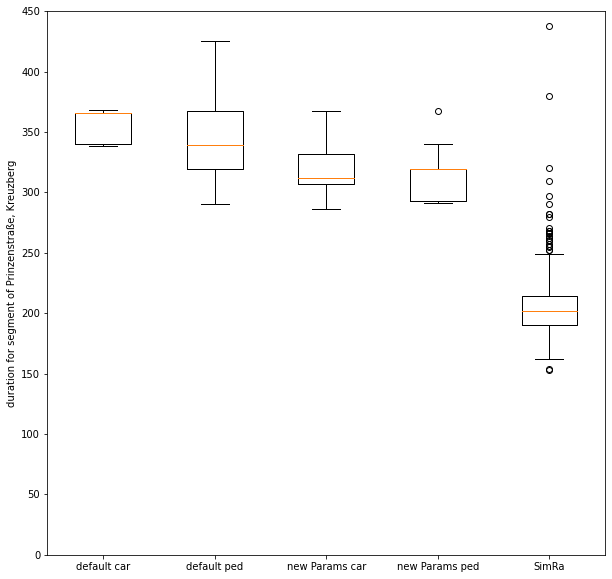

In [6]:
plt.figure(figsize=(10,10))

#plt.boxplot(durations)
plt.boxplot(durations_arr)
plt.xticks(np.arange(len(durations_arr)) + 1, ['default car', 'default ped','new Params car', 'new Params ped', 'SimRa'])
plt.ylabel('duration for segment of Prinzenstraße, Kreuzberg')
plt.ylim(0,450)
plt.savefig('images/sim_prinzenstr.png', bbox_inches='tight')
print(np.mean(durations_arr[0]))

In [8]:
durations_prinzenstr = durations_arr

%store durations_prinzenstr

Stored 'durations_prinzenstr' (list)
